##4.1 A LiDAR example
Here we are going to generate a LiDAR waveform using the <code><span style="background-color:lightgrey">obj/sphere.obj</span></code> from the very first example.  The image below shows the return energy as a function of time

<img src=img/lidar.gif width=400>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from run_start import *
from hips import hips2img
from generate_camera_file import update_existing_camera

##<code><span style="background-color:lightgrey">camera/simple.lidar</span></code></p>
<code>
    camera {  <span style=color:green><i># VERY important space between camera and brace</i></span>
      camera.name  = "lidar camera";
      geometry.perspective = TRUE; 
      geometry.idealArea = 100000
      geometry.azimuth = 0.0;
      geometry.zenith = 0.0;
      geometry.twist = 0.0;
      geometry.lookAt = 0, 0, 0;
      geometry.boomLength = 10000.;
      samplingCharacteristics.nPixels = 262144;
      samplingCharacteristics.rpp = 1;
      result.samplingImage = "output/lidar_sphere.hips"
      result.integral.mode = "distance" <span style=color:green><i># specify "distance" here</i></span>
      result.integral = "output/lidar_integral.dat"
      lidar.nBins = 150 <span style=color:green><i># number of bins that are recorded</i></span>
      lidar.binStart = 14000 <span style=color:green><i># when to start recording</i></span>
      lidar.binStep = 1000 <span style=color:green><i># size of bin steps</i></span>
    } 
</code>

There are a couple of differences here between this and the <code><span style="background-color:lightgrey">camera/simple.camera</span></code> used in previous examples.  These include:

<code>result.integral.mode</code> now records <code>"distance"</code> instead of <code>"scattering order"</code> or <code>"wavelength"</code>.

There are also a numer of <code>lidar</code> variables.  From the <code><span style="background-color:lightgrey">obj/sphere.obj</span></code> we can see that it is  3000 (arbitary) units high. The camera is located at 10000 units (<code>geometry.boomLength</code>), so the distance between camera and the top of the spheroid is 7000 units. The 'return' distance is the same, so the minimum distance is 14000 units. Thus, we start lidar sampling at 14000 units (<code>lidar.binStart</code>). 

The ground is at distance 10000 units from camera and light, but with a perspecive camera (and light source) for lidar, the maximum distance to ground (viewing a region of linear dimension 100000 units) is $\sqrt{10000^2 + 50000^2} = 50990$. The maximum return trip (for first-order scattering) then is twice this = 101980.4 units.

If we wish sampling of 1000 units (<code>lidar.binStep</code>) in the lidar, we need at least $(101981 - 14000)/1000 = 88$ sampling bins (<code>lidar.nBins</code>). We decide on 150 to account for other effects.

Note that this is rather an artificial scenario: we do not usually simulate sich wide field of view lidars, so fewer bins (that can be calculated from small angle approximations) are normally sufficient. 

hips.py:53: RuntimeWarning: invalid value encountered in divide
  arr_b = ((arr_b - np.percentile(arr_b, 2.5)) / np.percentile(arr_b, 97.5))
hips.py:54: RuntimeWarning: invalid value encountered in less
  arr_b[arr_b < 0] = 0
hips.py:55: RuntimeWarning: invalid value encountered in greater
  arr_b[arr_b > 1] = 1
hips.py:53: RuntimeWarning: divide by zero encountered in divide
  arr_b = ((arr_b - np.percentile(arr_b, 2.5)) / np.percentile(arr_b, 97.5))


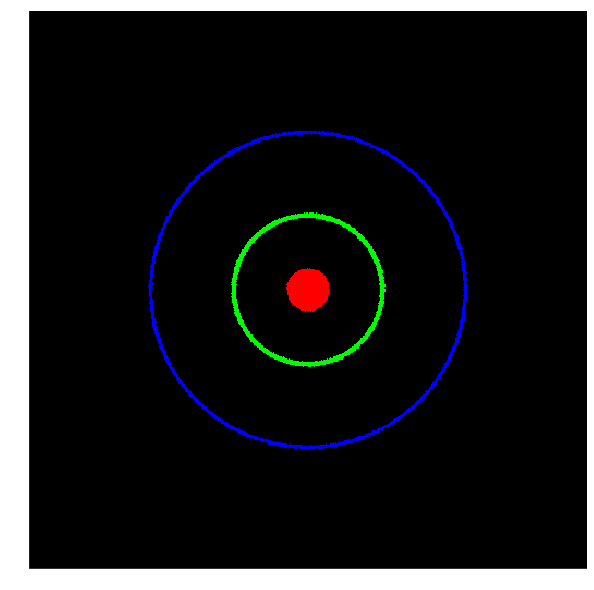

In [2]:
# we have specified the brdf_wavband.dat as this has only one band
# we are using the same light source as the camera options.
cmd = 'echo 14 camera/simple.lidar light/simple.lidar | \
       start -RATm 1 -RATsensor_wavebands wb/brdf_waveband.dat obj/sphere.obj'
error = run_start(cmd)

if not error:
    # we can look at a slice of the resulting image using the 'order'
    # option, in this case we are looking at lidar.nBins steps 0, 10, 30
    hips2img('output/perspective_lidar.hips', stretch=True, order=[1, 10, 30])

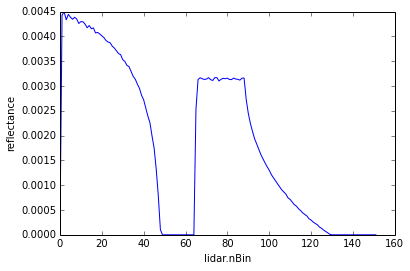

In [3]:
# We can then look at the results of this by plotting
# reflectance against bin number
refl = np.loadtxt('output/perspective_lidar.dat.direct')
plt.plot(refl[:, 1])
plt.xlabel('lidar.nBin')
plt.ylabel('reflectance')

##Modifying <code><span style="background-color:lightgrey">light/simple.lidar</span></code> to create a pulsed illumination</p>
The above code ran a simple lidar using a persepctive light source:</p>
<code>
    camera {
    camera.name = "simple illumination";
    geometry.perspective = "TRUE";
    geometry.idealArea = 100000.0;
    geometry.azimuth = 0.0;
    geometry.zenith = 0.0;
    geometry.twist = 0.0;
    geometry.lookAt = 0,0,0;
    geometry.boomLength = 10000.0;
</code>

To make this a more realitic LiDAR simulator, we can create a pulse of light using the <code>lidar</code> options.</p>
<code>
    lidar.pulseStart = 5000; <span style=color:green><i># start of pulse, make this half the pulse length for a Gaussian</i></span>
    lidar.pulseForm = "gaussian"; <span style=color:green><i># shape of pulse (square or gaussian)</i></span>
    lidar.pulseSD = 3.0; <span style=color:green><i># how much of a Gaussian?</i></span>
    lidar.pulseLength = 10000.0; <span style=color:green><i># length of pulse</i></span>
    lidar.pulseSamples = 100; <span style=color:green><i># number of samples for discrete representation</i></span>
    lidar.pulseOPFile = "light/pulse.dat"; <span style=color:green><i># filename in case want to store representation</i></span>
</code>



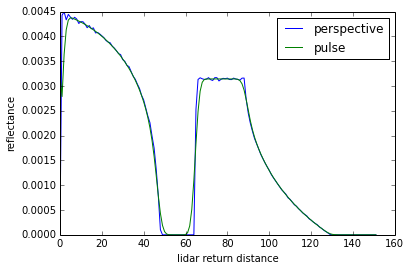

In [4]:
cmd = 'echo 14 camera/pulse.lidar light/pulse.lidar | \
       start -RATm 1 -RATsensor_wavebands wb/brdf_waveband.dat obj/sphere.obj'
error = run_start(cmd)

if not error:
    # we can look at a slice of the resulting image using the 'order'
    # option, in this case we are looking at slices 0, 10, 30
    refl = np.loadtxt('output/perspective_lidar.dat.direct')
    plt.plot(refl[:, 1:].mean(axis=1), label='perspective')
    refl = np.loadtxt('output/pulse_lidar.dat.direct')
    plt.plot(refl[:, 1:].mean(axis=1), label='pulse')
    plt.legend(loc='best')
    plt.xlabel('lidar return distance')
    plt.ylabel('reflectance')

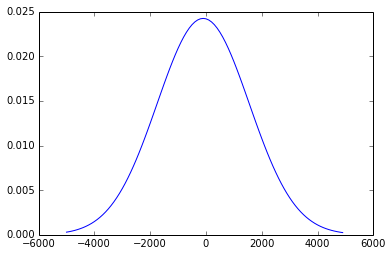

In [5]:
# We can visualise the pulsed waveform
pulse = np.loadtxt('pulse.dat')
bins = np.arange(-5000, 5000)[::10000/100] # lidar.pulseLength sampled lidar.pulseSamples times
plt.plot(bins, pulse)

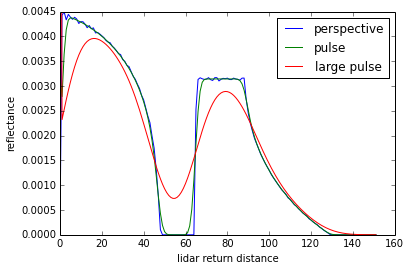

In [6]:
# update camera and illumination
oname = 'output/50000_lidar'
update_existing_camera('camera/pulse.lidar', 'camera/pulse_50000sd.lidar',
                        oname=oname)

update_existing_camera('light/pulse.lidar', 'light/pulse_50000sd.lidar',
                       new_options={'lidar.pulseStart':25000,
                                    'lidar.pulseLength':50000,
                                    'lidar.pulseOPFile':'light/pulse_long.dat'})

cmd = 'echo 14 camera/pulse_50000sd.lidar light/pulse_50000sd.lidar | \
       start -RATm 1 -RATsensor_wavebands wb/brdf_waveband.dat obj/sphere.obj'
error = run_start(cmd)

if not error:
    # we can look at a slice of the resulting image using the 'order'
    # option, in this case we are looking at slices 0, 10, 30
    refl = np.loadtxt('output/perspective_lidar.dat.direct')
    plt.plot(refl[:, 1:].mean(axis=1), label='perspective')
    refl = np.loadtxt('output/pulse_lidar.dat.direct')
    plt.plot(refl[:, 1:].mean(axis=1), label='pulse')
    refl = np.loadtxt('{}.dat.direct'.format(oname))
    plt.plot(refl[:, 1:].mean(axis=1), label='large pulse')
    plt.legend(loc='best')
    plt.xlabel('lidar return distance')
    plt.ylabel('reflectance')
    plt.ylim(0, .0045)

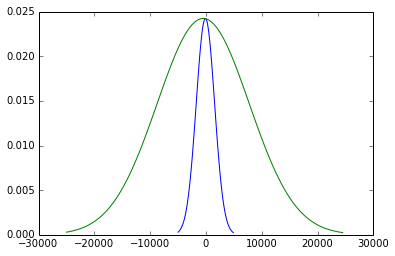

In [62]:
# and now compare the pulses
bins = np.arange(-5000, 5000)[::10000/100] # lidar.pulseLength sampled lidar.pulseSamples times
pulse_short = np.loadtxt('light/pulse.dat')
plt.plot(bins, pulse_short)

bins = np.arange(-25000, 25000)[::50000/100]
pulse_long = np.loadtxt('light/pulse_long.dat')
plt.plot(bins, pulse_long)